In [1]:
import joblib
import random
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import cv2
import numpy as np
import pandas as pd
import cv2
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm

In [2]:
def extract_features(img, return_visuals=False):

    features = []
    visuals = {} if return_visuals else None

    # Color Histogram (HSV, 4x4x4=64)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [4, 4, 4], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    features.append(hist)
    if return_visuals:
        visuals["hsv"] = hsv
        visuals["color_hist_channels"] = [
            cv2.calcHist([hsv], [0], None, [4], [0, 180]),  # Hue
            cv2.calcHist([hsv], [1], None, [4], [0, 256]),  # Sat
            cv2.calcHist([hsv], [2], None, [4], [0, 256]),  # Val
        ]

    # Contours for Hu Moments and Size/Positions (appx ~ 11 values)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = None
    if contours:
        cnt = max(contours, key=cv2.contourArea)  # To capture largest (main obj)
        contour_img = img.copy()
        # Hu Moments (appx ~ 7 values)
        moments = cv2.moments(cnt)
        hu_moments = cv2.HuMoments(moments).flatten()
        # Size/ Positions (appx ~4 values normalized)
        x, y, w, h = cv2.boundingRect(cnt)
        size_pos = np.array(
            [w / img.shape[1], h / img.shape[0], x / img.shape[1], y / img.shape[0]]
        )
    else:
        hu_moments = np.zeros(7)
        size_pos = np.zeros(4)
    features.append(hu_moments)
    features.append(size_pos)

    if return_visuals:
        visuals["gray"] = gray
        visuals["contour_img"] = contour_img
        visuals["hu_moments"] = hu_moments
        visuals["size_pos"] = size_pos

    # LBP (Texture, appx ~ 59 values)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), range=(0, 59))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum() + 1e-7  # Normalize
    features.append(lbp_hist)

    if return_visuals:
        visuals["lbp"] = lbp
        visuals["lbp_hist"] = lbp_hist

    # GLCM (Texture stats appx ~ 3 values)
    glcm_gray = cv2.resize(gray, (64, 64))
    glcm = graycomatrix(
        glcm_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True
    )
    contrast = graycoprops(glcm, "contrast")[0, 0]
    homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
    energy = graycoprops(glcm, "energy")[0, 0]
    glcm_feats = np.array([contrast, homogeneity, energy]).flatten()
    features.append(glcm_feats)

    if return_visuals:
        visuals["glcm"] = glcm[:, :, 0, 0]
        visuals["glcm_stats"] = (contrast, homogeneity, energy)

    # HOG (Shape/Gradient 16x16 image)
    hog_feats, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=True
    )
    features.append(hog_feats)
    if return_visuals:
        visuals["hog_image"] = hog_image

    feature_vector = np.hstack(features).flatten()
    if return_visuals:
        return feature_vector, visuals
    else:
        return feature_vector

In [3]:
def load_dataset(data_dir="data/coil-100"):
    images = []
    data_dir = (
        "/home/itz-amethyst/dev/AI_Space/projects/ML/object-sorting/data/coil-100/"
    )
    labels = []
    files = [f for f in os.listdir(data_dir) if f.endswith(".png")]

    for filename in tqdm(files, desc="Loading COIL-100 images"):
        if filename.endswith(".png"):
            img_path = os.path.join(data_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                label = int(
                    filename.split("__")[0].replace("obj", "")
                )  # output: 1 from 'obj1__0.png'
                labels.append(label)

    return np.array(images), np.array(labels)


images, labels = load_dataset()
print(f"Loaded {len(images)} images with {len(np.unique(labels))} classes.")

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded

feature_list = [extract_features(img).flatten() for img in images]
feature_vectors = np.vstack(feature_list)
print(f"Feature shape: {feature_vectors.shape}")


Loading COIL-100 images:   0%|          | 0/7200 [00:00<?, ?it/s]


Loading COIL-100 images:   3%|▎         | 239/7200 [00:00<00:02, 2379.54it/s]


Loading COIL-100 images:   7%|▋         | 482/7200 [00:00<00:02, 2404.96it/s]


Loading COIL-100 images:  10%|█         | 723/7200 [00:00<00:02, 2307.41it/s]


Loading COIL-100 images:  14%|█▎        | 980/7200 [00:00<00:02, 2405.83it/s]


Loading COIL-100 images:  17%|█▋        | 1252/7200 [00:00<00:02, 2513.93it/s]


Loading COIL-100 images:  21%|██        | 1504/7200 [00:00<00:02, 2438.26it/s]


Loading COIL-100 images:  24%|██▍       | 1749/7200 [00:00<00:02, 2323.29it/s]


Loading COIL-100 images:  28%|██▊       | 1993/7200 [00:00<00:02, 2355.73it/s]


Loading COIL-100 images:  31%|███▏      | 2267/7200 [00:00<00:01, 2469.41it/s]


Loading COIL-100 images:  35%|███▍      | 2516/7200 [00:01<00:01, 2453.93it/s]


Loading COIL-100 images:  38%|███▊      | 2763/7200 [00:01<00:01, 2398.77it/s]


Loading COIL-100 images:  42%|████▏     | 3021/7200 [00:01<00:01, 2450.75it/s]


Loading COIL-100 images:  45%|████▌     | 3267/7200 [00:01<00:01, 2397.78it/s]


Loading COIL-100 images:  49%|████▊     | 3508/7200 [00:01<00:01, 2351.47it/s]


Loading COIL-100 images:  52%|█████▏    | 3744/7200 [00:01<00:01, 2302.77it/s]


Loading COIL-100 images:  55%|█████▌    | 3975/7200 [00:01<00:01, 2225.82it/s]


Loading COIL-100 images:  59%|█████▊    | 4227/7200 [00:01<00:01, 2307.61it/s]


Loading COIL-100 images:  62%|██████▏   | 4459/7200 [00:01<00:01, 2280.30it/s]


Loading COIL-100 images:  65%|██████▌   | 4688/7200 [00:01<00:01, 2274.21it/s]


Loading COIL-100 images:  68%|██████▊   | 4926/7200 [00:02<00:00, 2303.68it/s]


Loading COIL-100 images:  72%|███████▏  | 5160/7200 [00:02<00:00, 2313.68it/s]


Loading COIL-100 images:  75%|███████▍  | 5392/7200 [00:02<00:00, 2306.52it/s]


Loading COIL-100 images:  78%|███████▊  | 5640/7200 [00:02<00:00, 2356.69it/s]


Loading COIL-100 images:  82%|████████▏ | 5876/7200 [00:02<00:00, 2262.42it/s]


Loading COIL-100 images:  85%|████████▌ | 6120/7200 [00:02<00:00, 2313.43it/s]


Loading COIL-100 images:  89%|████████▊ | 6378/7200 [00:02<00:00, 2388.44it/s]


Loading COIL-100 images:  92%|█████████▏| 6649/7200 [00:02<00:00, 2480.41it/s]


Loading COIL-100 images:  96%|█████████▌| 6903/7200 [00:02<00:00, 2496.87it/s]


Loading COIL-100 images:  99%|█████████▉| 7154/7200 [00:03<00:00, 2469.31it/s]


Loading COIL-100 images: 100%|██████████| 7200/7200 [00:03<00:00, 2374.24it/s]

Loaded 7200 images with 100 classes.


Feature shape: (7200, 1901)


In [4]:
## Feature reduction

# PCA: AUto-select components
scaler = StandardScaler()
feature_vectors_scaled = scaler.fit_transform(feature_vectors)

pca = PCA(n_components=0.95)
pca.fit(feature_vectors_scaled)
feature_vectors_reduced = pca.transform(feature_vectors_scaled)
print(f"Reduced Shape: {feature_vectors_reduced.shape}")
print(f"Explained Variance: {pca.explained_variance_ratio_.sum()}")

# Selector
selector = SelectKBest(f_classif, k=500)
selector.fit(feature_vectors_scaled, labels_encoded)
feature_vectors_selected = selector.transform(feature_vectors_scaled)
print(f"Selected Shape: {feature_vectors_selected.shape}")

# scores = selector.scores_
# print(f'Top 10 feature scors:', np.sort(scores)[-10:])

# Combo: to Apply selection first, then PCA on selected features
feature_vectors_selected = selector.transform(feature_vectors_scaled)
pca_combo = PCA(n_components=0.95)
pca_combo.fit(feature_vectors_selected)
feature_vectors_combo = pca_combo.transform(feature_vectors_selected)
print(f"Combo reduced Shape: {feature_vectors_combo.shape}")

Reduced Shape: (7200, 385)
Explained Variance: 0.9500674720987896
Selected Shape: (7200, 500)


Combo reduced Shape: (7200, 158)


/home/itz-amethyst/venvs/global-venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 64  65  66  67  68  69  70  71  72  73  74  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/itz-amethyst/venvs/global-venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [5]:

original_indices = np.arange(len(images))
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    feature_vectors_combo,
    labels_encoded,
    original_indices,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded,
)

models = {
    "SVM": SVC(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
}

param_distributions = {
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto", 0.1, 1],
        "kernel": ["rbf", "linear"],
    },
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },
}

In [6]:
# Perform RandomizedSearchCV
best_models = {}
best_scores = {}
for name, model in models.items():
    print(f"Tuning {name} ...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=10,
        cv=5,
        n_jobs=-1,
        random_state=42,
        scoring="accuracy",
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_
    print(f"Best params for {name}: {search.best_params_}")
    print(f"Best CV accuracy for {name}: {search.best_score_:.3f}")

# select the best model
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(
    f"Best overall model: {best_model_name} with CV accuracy {best_scores[best_model_name]:.3f}"
)

Tuning SVM ...


Best params for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100}
Best CV accuracy for SVM: 0.997
Tuning RandomForest ...


Best params for RandomForest: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Best CV accuracy for RandomForest: 0.969
Tuning KNN ...


Best params for KNN: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Best CV accuracy for KNN: 0.971
Best overall model: SVM with CV accuracy 0.997


In [7]:
# Evaluate on test set for all models
for name, model in best_models.items():
    pred = model.predict(X_test)
    print(f"{name} Test Accuracy: {accuracy_score(y_test, pred):.3f}")
    print(classification_report(y_test, pred))

scores = cross_val_score(estimator=best_model, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(f"CV accuracy scores: {scores}")
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

SVM Test Accuracy: 0.999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00        14
  

KNN Test Accuracy: 0.985
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      0.93      0.96        14
           6       1.00      1.00      1.00        14
           7       1.00      0.86      0.92        14
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00        14
  

CV accuracy scores: [0.99826389 0.99826389 1.         0.99826389 1.         0.99826389
 0.99652778 1.         0.99826389 0.99652778]
CV accuracy: 0.998 +/- 0.001


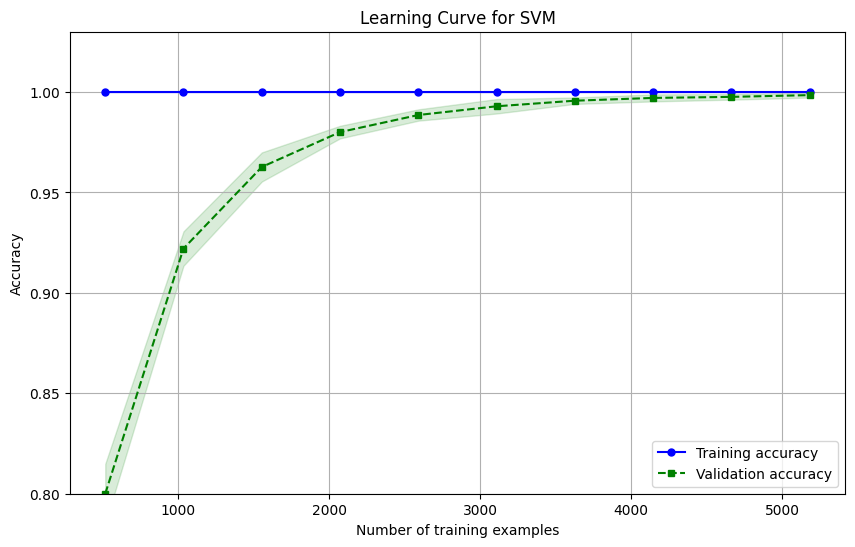

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=-1,
)

# Calculate means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(
    train_sizes,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="Training accuracy",
)
plt.fill_between(
    train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue",
)
plt.plot(
    train_sizes,
    test_mean,
    color="green",
    marker="s",
    markersize=5,
    linestyle="--",
    label="Validation accuracy",
)
plt.fill_between(
    train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green"
)
plt.grid()
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.03])
plt.legend(loc="lower right")
plt.title(f"Learning Curve for {best_model_name}")
plt.show()

In [9]:

def visualize_extracted_features(img):
    _, visuals = extract_features(img, return_visuals=True)

    fig, axs = plt.subplots(3, 3, figsize=(16, 14))
    axs = axs.flatten()
    i = 0

    # Input image
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title("Input Image")
    axs[i].axis("off")
    i += 1

    # Color histogram
    axs[i].plot(visuals["color_hist_channels"][0], "r-", label="Hue")
    axs[i].plot(visuals["color_hist_channels"][1], "g-", label="Saturation")
    axs[i].plot(visuals["color_hist_channels"][2], "b-", label="Value")
    axs[i].set_title("HSV Color Histograms (4 bins)")
    axs[i].legend()
    i += 1

    # Contours + bounding box
    if visuals["contour_img"] is not None:
        axs[i].imshow(cv2.cvtColor(visuals["contour_img"], cv2.COLOR_BGR2RGB))
        axs[i].set_title("Largest Contour & Bounding Box")
    else:
        axs[i].text(0.5, 0.5, "No contour found", ha="center", va="center")
    axs[i].axis("off")
    i += 1

    # LBP map
    axs[i].imshow(visuals["lbp"], cmap="gray")
    axs[i].set_title("Local Binary Patterns (Texture)")
    axs[i].axis("off")
    i += 1

    # LBP histogram
    axs[i].bar(range(len(visuals["lbp_hist"])), visuals["lbp_hist"])
    axs[i].set_title("LBP Uniform Histogram")
    axs[i].set_xlabel("Bin")
    axs[i].set_xlim(0, 10)
    axs[i].set_ylabel("Normalized Frequency")
    i += 1

    # GLCM slice + stats
    axs[i].imshow(visuals["glcm"], cmap="hot", interpolation="nearest")
    axs[i].set_title("GLCM (Co-occurrence slice)")
    axs[i].axis("off")
    contrast, homo, energy = visuals["glcm_stats"]
    axs[i].text(
        5,
        5,
        f"Contrast: {contrast:.3f}\nHomogeneity: {homo:.3f}\nEnergy: {energy:.3f}",
        color="white",
        fontsize=10,
        bbox=dict(facecolor="black", alpha=0.6),
    )
    i += 1

    # HOG visualization
    axs[i].imshow(visuals["hog_image"], cmap="gray")
    axs[i].set_title("HOG Gradient Visualization")
    axs[i].axis("off")
    i += 1

    for ax in axs[i:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    print("Hu Moments:", visuals["hu_moments"])
    print("Normalized Size/Position (w, h, x, y):", visuals["size_pos"])
    print("\nFeature vector length:", len(_)) 

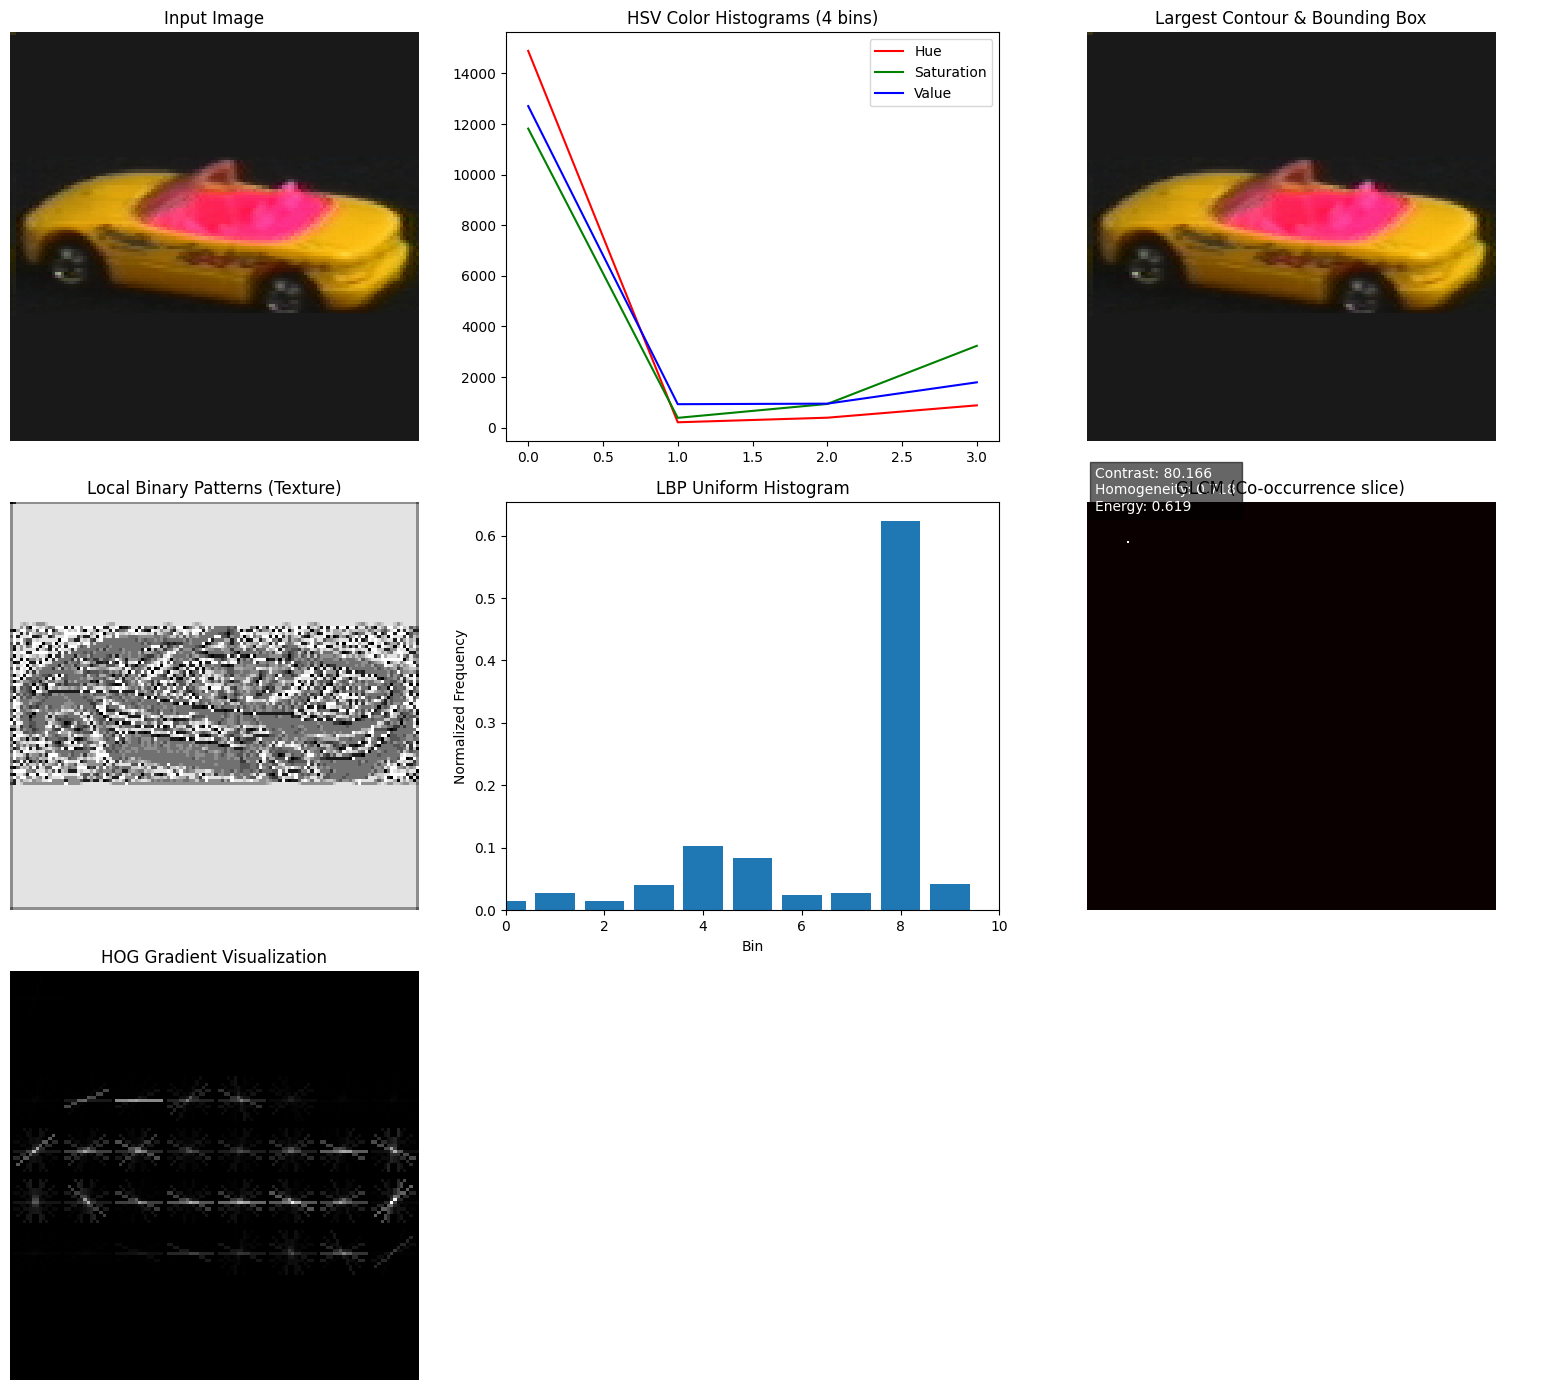

Hu Moments: [ 1.66666667e-01  3.28103194e-33  6.66581031e-33  6.66581031e-33
  4.44330271e-65 -3.81819566e-49  0.00000000e+00]
Normalized Size/Position (w, h, x, y): [1. 1. 0. 0.]

Feature vector length: 1901


In [10]:
idx = random.randint(0, len(X_test) - 1)
original_img_idx = test_idx[idx]
img = images[original_img_idx]

visualize_extracted_features(img)

In [11]:
# To save trained model checkpoints
checkpoint_dir = "./projects/ML/object-sorting/chckpoints/coil100-sorting-model"
os.makedirs(checkpoint_dir, exist_ok=True)

joblib.dump(best_model,          os.path.join(checkpoint_dir, "model.joblib"))
joblib.dump(scaler,              os.path.join(checkpoint_dir, "scaler.joblib"))
joblib.dump(selector,            os.path.join(checkpoint_dir, "selector.joblib"))
joblib.dump(pca_combo,           os.path.join(checkpoint_dir, "pca.joblib"))
joblib.dump(le,                  os.path.join(checkpoint_dir, "label_encoder.joblib"))

['./projects/ML/object-sorting/chckpoints/coil100-sorting-model/label_encoder.joblib']